# **Homework 4 - Hard coding**

## **1. Implementing your own Shazam**

In [107]:
# Import some useful libraries
import numpy as np      
import matplotlib.pyplot as plt 
import scipy.io.wavfile 
import subprocess
import librosa
import librosa.display
import IPython.display as ipd
import pandas as pd
import random as rd
import math
import time

from collections import defaultdict
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import preprocessing
from pandas.api.types import is_string_dtype, is_numeric_dtype
from numpy import linalg
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from pathlib import Path, PurePath   
from tqdm.notebook import tqdm

# Import our functions

In [108]:
def convert_mp3_to_wav(audio:str) -> str:  
    """Convert an input MP3 audio track into a WAV file.

    Args:
        audio (str): An input audio track.

    Returns:
        [str]: WAV filename.
    """
    if audio[-3:] == "mp3":
        wav_audio = audio[:-3] + "wav"
        if not Path(wav_audio).exists():
                subprocess.check_output(f"ffmpeg -i {audio} {wav_audio}", shell=True)
        return wav_audio
    
    return audio

def plot_spectrogram_and_peaks(track:np.ndarray, sr:int, peaks:np.ndarray, onset_env:np.ndarray) -> None:
    """Plots the spectrogram and peaks 

    Args:
        track (np.ndarray): A track.
        sr (int): Aampling rate.
        peaks (np.ndarray): Indices of peaks in the track.
        onset_env (np.ndarray): Vector containing the onset strength envelope.
    """
    times = librosa.frames_to_time(np.arange(len(onset_env)),
                            sr=sr, hop_length=HOP_SIZE)

    plt.figure()
    ax = plt.subplot(2, 1, 2)
    D = librosa.stft(track)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=np.max),
                            y_axis='log', x_axis='time')
    plt.subplot(2, 1, 1, sharex=ax)
    plt.plot(times, onset_env, alpha=0.8, label='Onset strength')
    plt.vlines(times[peaks], 0,
            onset_env.max(), color='r', alpha=0.8,
            label='Selected peaks')
    plt.legend(frameon=True, framealpha=0.8)
    plt.axis('tight')
    plt.tight_layout()
    plt.show()

def load_audio_peaks(audio, offset, duration, hop_size):
    """Load the tracks and peaks of an audio.

    Args:
        audio (string, int, pathlib.Path or file-like object): [description]
        offset (float): start reading after this time (in seconds)
        duration (float): only load up to this much audio (in seconds)
        hop_size (int): the hop_length

    Returns:
        tuple: Returns the audio time series (track) and sampling rate (sr), a vector containing the onset strength envelope
        (onset_env), and the indices of peaks in track (peaks).
    """
    try:
        track, sr = librosa.load(audio, offset=offset, duration=duration)
        onset_env = librosa.onset.onset_strength(track, sr=sr, hop_length=hop_size)
        peaks = librosa.util.peak_pick(onset_env, 10, 10, 10, 10, 0.5, 0.5)
    except Error as e:
        print('An error occurred processing ', str(audio))
        print(e)

    return track, sr, onset_env, peaks

In [109]:
N_TRACKS = 1413
HOP_SIZE = 512
OFFSET = 1.0
DURATION = 30 # TODO: to be tuned!
THRESHOLD = 0 # TODO: to be tuned!

In [110]:
data_folder = Path("data/mp3s-32k/")
mp3_tracks = data_folder.glob("*/*/*.mp3")
tracks = data_folder.glob("*/*/*.wav")

### Preprocessing

In [12]:
for track in tqdm(mp3_tracks, total=N_TRACKS):
    convert_mp3_to_wav(str(track))

  0%|          | 0/1413 [00:00<?, ?it/s]

### Audio signals

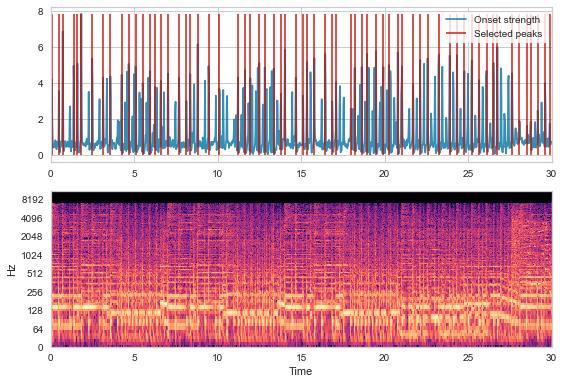

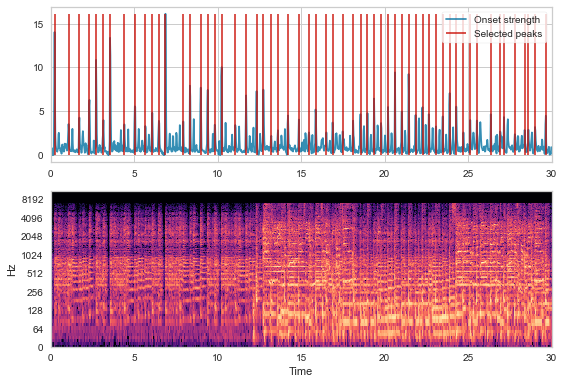

In [5]:
for idx, audio in enumerate(tracks):
    if idx >= 2:
        break
    track, sr, onset_env, peaks = load_audio_peaks(audio, OFFSET, DURATION, HOP_SIZE)
    plot_spectrogram_and_peaks(track, sr, peaks, onset_env)

In [18]:
maxPeak = 0

start_time = time.time()

for idx, audio in enumerate(tracks):
    track, sr, onset_env, peaks = load_audio_peaks(audio, OFFSET, DURATION, HOP_SIZE)
    if max(peaks) > maxPeak:
        maxPeak = max(peaks)

print('It took %s seconds to find the max peak.' %(time.time()-start_time))


print("maxPeak: ", maxPeak)

It took 557.2503147125244 seconds to find the max peak.
maxPeak:  1291


In [13]:
tracks

<generator object Path.glob at 0x000001A2CDE6F510>

In [112]:
start_time = time.time()

matrix = np.empty((0,0))
for idx, audio in enumerate(tracks):
    track, sr, onset_env, peaks = load_audio_peaks(audio, OFFSET, DURATION, HOP_SIZE)
    new_arr = np.zeros((1292))
    for j in peaks:
        new_arr[j] = 1
    matrix = np.append(matrix, new_arr)
    
print('It took %s seconds to find the frequency matrix of the peaks' %(time.time()-start_time))

#matrix = np.reshape(matrix, (1292, int(matrix.shape[0]/1292)))
matrix


It took 885.009505033493 seconds to find the frequency matrix of the peaks


array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [113]:
matrix.shape

(1292, 1305)

In [120]:
len(peaks)

69

In [ ]:
#permutation 
rr = range(1291) #number of rows
np.random.shuffle(rr) 
np.take(matrix, rr, axis=0)

In [ ]:

index = []
for i in range(matrix.shape[1]):
    for j in range(matrix.shape[0]):
        if matrix[i][j] == 1:
            index.append(i)

In [7]:
sr

22050

In [8]:
track[1277]

0.0021324265

In [9]:
onset_env

array([0.        , 0.        , 0.        , ..., 0.1758712 , 0.13490105,
       0.9178963 ], dtype=float32)

## **2. Grouping songs together!**

*We play with a dataset gathering songs from the International Society for Music Information Retrieval Conference. The tracks (songs) include much information. We focus on the track information, features (extracted with librosa library from Python) and audio variables provided by Echonest (now Spotify).*

### **2.1 Getting your data!**

In [5]:
# We use this function to clean our dataset, in particular to fill the NaN values.
def fill_nan(df):
    for i in df.columns:
        if df[i].isnull().any() == True:
            # Check for columns with NaN values
            if is_numeric_dtype(df[i]) == True:
                # If is a numeric column fillna with the mean of the column
                df[i] = df[i].fillna(df[i].mean())
            elif is_string_dtype(df[i]) == True:
                # If is a string column fill na with an empty string
                df[i] = df[i].fillna("")
    
    print('All NaN filled!')         

We upload, using *pandas*, three different csv dataset: *tracks.csv*, *features.csv* and *echonest.csv*.

In [6]:
tracks = pd.read_csv("tracks.csv")
echonest = pd.read_csv("echonest.csv")
features = pd.read_csv("features.csv")

We can get a look at these three different datasets. Let's start with *tracks*.

In [7]:
print(tracks.shape)
tracks.head()

(106574, 53)


,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,...,NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
4,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,...,NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


With our function *'fill_nan'* we preprocess our dataset filling NaN values.

In [8]:
fill_nan(tracks)

All NaN filled!


In [9]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   track_id                  106574 non-null  int64  
 1   album_comments            106574 non-null  int64  
 2   album_date_created        106574 non-null  object 
 3   album_date_released       106574 non-null  object 
 4   album_engineer            106574 non-null  object 
 5   album_favorites           106574 non-null  int64  
 6   album_id                  106574 non-null  int64  
 7   album_information         106574 non-null  object 
 8   album_listens             106574 non-null  int64  
 9   album_producer            106574 non-null  object 
 10  album_tags                106574 non-null  object 
 11  album_title               106574 non-null  object 
 12  album_tracks              106574 non-null  int64  
 13  album_type                106574 non-null  o

*Tracks* has 106,573 observations over 53 features. Most of the features regards information and descriptions about the track, the album and the artist. There are both numerical (18) and string-type (35) variables.

Now, we can look at *features*.

In [10]:
print(features.shape)
features.head()

(106574, 519)


,track_id,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
4,20,-0.193837,-0.198527,0.201546,0.258556,0.775204,0.084794,-0.289294,-0.816410,0.043851,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993


In [11]:
fill_nan(features)

All NaN filled!


In [12]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Columns: 519 entries, track_id to zcr_std_01
dtypes: float64(518), int64(1)
memory usage: 422.0 MB


*Features* has 106,574 observations over 519 features. There are only numeric variables regarding some measures about the tracks.

Finally, we look at *echonest*.

In [13]:
print(echonest.shape)
echonest.head()

(13129, 250)


,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_album_date,...,temporal_features_214,temporal_features_215,temporal_features_216,temporal_features_217,temporal_features_218,temporal_features_219,temporal_features_220,temporal_features_221,temporal_features_222,temporal_features_223
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,NaN,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,NaN,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,NaN,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.92649,5.86635,16.013849,356.755737
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,2008-03-11,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.41401,8.33319,21.317064,483.403809
4,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,NaN,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.26707,11.20267,26.454180,751.147705


In [14]:
fill_nan(echonest)

All NaN filled!


In [15]:
echonest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13129 entries, 0 to 13128
Columns: 250 entries, track_id to temporal_features_223
dtypes: float64(244), int64(1), object(5)
memory usage: 25.0+ MB


*Echonest* has 13129 observations over 250 features. These are features extracted by Spotify about some particular characteristics of the tracks. There are 245 numerical and 5 string variables.

### **2.2 Choose your features (variables)!**

We decided to perform **PCA** on these three datasets in order to reduce their dimensionality. Before applying the PCA, we need to do two important things:

1. Remove all the 'object' dtypes variable from the datasets because they can't be fitted into the PCA.

In [16]:
# We want to consider only non-object types of variable to perform PCA.
def remove_object_dtype(df):
    new_df = df.select_dtypes(exclude = 'object') 
    return new_df

2. Standardize our values to eliminate problems derived by different scales and unity measures.


In [17]:
# We leverage the StandardScaler module from sklearn.preprocessing
def scale_f(df):
    scaler = preprocessing.StandardScaler()
    # We don't want to consider 'track_id' - the first col - because we need it for the merge
    new_df = pd.DataFrame(scaler.fit_transform(df[df.columns[1:]].values), columns = df.columns[1:])
    # Add track_id
    final_df = pd.concat([df[df.columns[:1]], new_df], axis = 1)
    
    return final_df

Let's start working with the *echonest* dataframe.

In [18]:
# Remove object dtype variables
echonest_r = remove_object_dtype(echonest)

# Standardize the remaining values 
echonest_s = scale_f(echonest_r)

# Give a look at our ready-to-analyze dataset
echonest_s.head()

,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_artist_latitude,...,temporal_features_214,temporal_features_215,temporal_features_216,temporal_features_217,temporal_features_218,temporal_features_219,temporal_features_220,temporal_features_221,temporal_features_222,temporal_features_223
0,2,-0.281499,0.991915,0.348732,-1.742887,-0.064267,0.437749,1.223573,0.495983,-0.542858,...,-0.015394,-0.196498,-0.541629,-0.746474,-0.039156,-0.406800,-0.101961,-0.101075,0.886203,0.549691
1,3,-0.391656,0.217484,1.006860,-1.767172,-0.518358,2.639805,0.110726,-0.617788,-0.542858,...,0.224575,-0.092590,-0.360448,-0.411759,-0.023682,-0.402225,0.382370,0.383292,1.407079,0.827430
2,5,-1.253885,1.358338,0.589683,-1.770366,1.172705,0.185049,-0.651745,0.659017,-0.542858,...,-0.188685,0.038956,-0.372166,-0.209735,-0.029780,-0.767287,0.350908,0.352630,1.304715,0.965630
3,10,1.112791,0.898745,1.391929,0.898939,-0.457654,-0.481812,-0.328958,1.897809,-0.000715,...,-0.993299,0.536708,-0.182877,0.139612,-0.010956,1.124812,0.851688,0.849294,2.127603,1.527072
4,134,-0.188870,0.136465,0.082343,-1.718498,-0.577286,3.103507,-0.251046,1.645950,-0.542858,...,0.300454,-0.418382,-0.530095,-0.666811,-0.004175,-0.377522,1.426057,1.427025,2.924718,2.714005


Now, we can proceed with the PCA.

In [19]:
# We set 80 principal components.
pca1 = PCA(n_components=80)

# We don't want to perform it on the track_id column
echonest_red = pca1.fit_transform(echonest_s[echonest_s.columns[1:]])

# Show the total explained variance ratio
print(sum(pca1.explained_variance_ratio_))

0.8976662107225182


If we set 80 as number of principal components we get ~90% of explained total variance. That is our target, because at the end we want to preserve almost the 70% of the total variance of the merged dataset. Let's see in particular, how much variance is explained by every single component.

[0.11091527 0.08435649]


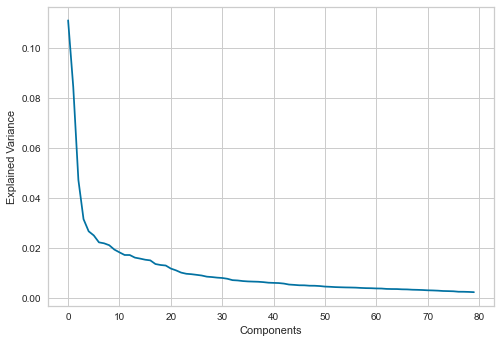

In [20]:
# Show the explained variance of the first two components
print(pca1.explained_variance_ratio_[:2])

# Plot the explained variance of the single principal components.
plt.plot(pca1.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.show()

Obviously the first components have higher values, in particular the first component explains the 11% of the variance and the second one the 8.4%. Now, we create our reducted dataframe with only 81 columns, against the starting 245 ones.

In [21]:
echonest_ = pd.DataFrame(echonest_red, columns = ['Comp_echo_%i' % i for i in range(80)])

# Re-add the track_id column 
echonest_pca = pd.concat([echonest['track_id'], echonest_], axis = 1)

echonest_pca.head()

,track_id,Comp_echo_0,Comp_echo_1,Comp_echo_2,Comp_echo_3,Comp_echo_4,Comp_echo_5,Comp_echo_6,Comp_echo_7,Comp_echo_8,...,Comp_echo_70,Comp_echo_71,Comp_echo_72,Comp_echo_73,Comp_echo_74,Comp_echo_75,Comp_echo_76,Comp_echo_77,Comp_echo_78,Comp_echo_79
0,2,0.779179,-1.709530,0.070456,0.467936,-1.452830,1.097074,-1.332257,0.347297,-0.606105,...,0.279020,0.309030,0.151965,0.124042,-0.594117,-0.142229,-0.297583,-0.280814,0.375268,-1.125187
1,3,2.659287,-4.168145,2.407970,-0.459533,0.069094,0.061468,1.349506,1.108546,-1.363261,...,-0.606973,0.382901,0.606143,0.392855,-0.229257,0.663476,-0.912879,-0.814178,0.636481,-0.069900
2,5,1.375855,-4.540360,2.340129,-0.065462,-0.875960,0.718837,1.769976,0.271999,0.766481,...,-0.129739,0.523473,0.001077,-0.368345,0.161409,-0.330084,-0.688745,-0.236431,0.708398,-0.853495
3,10,6.612744,-1.134204,0.394952,1.016468,1.060531,0.308434,-2.942900,0.637907,2.171829,...,-1.635331,-1.366938,-0.581039,0.355240,1.384180,-0.410897,-0.355964,1.018830,0.807910,0.058125
4,134,-2.917268,-5.523874,2.751432,-0.619102,0.590211,0.819118,0.538899,-0.309161,-0.320349,...,-0.252428,0.284929,-0.047094,-0.861426,-0.406434,0.218645,0.058717,-0.377175,-0.491370,-0.251147


Now we can repeat the same process for the *features* dataframe.

In [22]:
# Remove object dtype variables
features_r = remove_object_dtype(features)

# Standardize the remaining values 
features_s = scale_f(features_r)

# Give a look at our ready-to-analyze dataset
features_s.head()

,track_id,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,2,0.208784,0.452353,-0.008553,0.056482,0.079044,0.017718,0.071164,0.152168,0.090291,...,-1.200560,-1.537657,-1.595043,-0.266432,0.425841,1.007362,0.874131,-0.454603,-0.369213,0.775698
1,3,0.044880,0.050426,0.001063,0.106160,0.090461,-0.020371,0.064405,0.046439,-0.012742,...,-0.938948,-1.210805,-0.675913,-0.299409,0.463112,0.975158,0.643107,-0.454603,-0.491744,1.064853
2,5,0.002712,-0.024945,-0.061548,0.021789,0.109332,0.046419,-0.070494,-0.081502,0.063099,...,-1.561604,-1.461126,-1.162622,-0.254636,-0.034719,0.011006,-0.065367,-0.454603,-0.335249,0.167182
3,10,0.101044,-0.044147,0.186567,-0.026460,0.071382,0.056075,0.088195,0.081984,0.043355,...,-0.655213,-0.595296,-1.299392,-0.090255,0.385908,0.758699,0.889532,-0.454603,0.107731,0.018234
4,20,-0.019632,-0.035814,-0.013339,-0.000614,0.031972,-0.018958,-0.033153,-0.074345,-0.021467,...,-0.098756,0.151932,-0.085646,-0.143811,0.481748,-0.169453,-0.111572,-0.265064,-0.008018,-0.341557


In [23]:
# We set 150 principal components.
pca2 = PCA(n_components=150)

# We don't want to perform it on the track_id column
features_red = pca2.fit_transform(features_s[features_s.columns[1:]])

# Show the total explained variance ratio
print(sum(pca2.explained_variance_ratio_))


0.8985193458869447


If we set 150 as number of principal components we get ~90% of explained total variance. That is our target, because at the end we want to preserve almost the 70% of the total variance of the merged dataset. Let's see in particular, how much variance is explained by every single component.

[0.11981209 0.06802443]


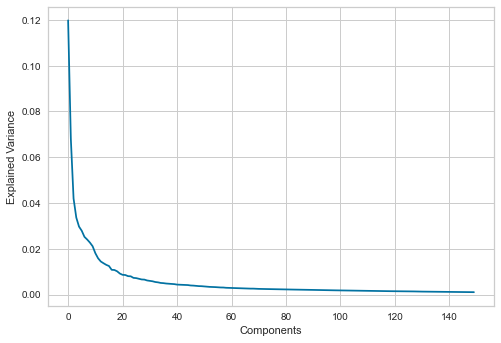

In [24]:
# Show the explained variance of the first two components
print(pca2.explained_variance_ratio_[:2])

# Plot the explained variance of the single principal components.
plt.plot(pca2.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.show()

The first principal component explains ~12% of the variance, the second one only the 6.8%. Now we can create our reducted dataframe, with 151 columns against the starting 519 ones.

In [25]:
features_ = pd.DataFrame(features_red, columns = ['Comp_feat_%i' % i for i in range(150)])

# Re-add the track_id column by concat
features_pca = pd.concat([features['track_id'], features_], axis = 1)

features_pca.head()

,track_id,Comp_feat_0,Comp_feat_1,Comp_feat_2,Comp_feat_3,Comp_feat_4,Comp_feat_5,Comp_feat_6,Comp_feat_7,Comp_feat_8,...,Comp_feat_140,Comp_feat_141,Comp_feat_142,Comp_feat_143,Comp_feat_144,Comp_feat_145,Comp_feat_146,Comp_feat_147,Comp_feat_148,Comp_feat_149
0,2,2.060070,-3.089439,-5.565923,0.080540,2.309269,-3.597831,-5.054211,-0.889464,-5.108315,...,0.220722,0.333813,-0.407256,-0.632276,-0.179975,0.182851,-0.744226,-0.241430,0.047290,-0.106751
1,3,3.509246,-5.384927,-4.332572,-1.113460,-3.068299,2.204037,-0.234569,4.726578,-0.604041,...,-0.560931,-0.361168,0.927699,-0.535041,0.363987,0.809608,-1.180409,-0.289296,-0.307637,-0.004627
2,5,0.954593,-3.178022,-3.494718,-0.934800,-1.098687,0.455750,-2.390566,1.266916,0.985001,...,-0.497056,-0.029645,0.266490,0.327341,0.081054,-0.389968,-0.207658,0.550131,-0.209042,-0.555218
3,10,6.695430,1.329784,-5.129153,-0.915313,-2.155916,-0.120454,0.072620,3.904954,0.213869,...,0.726335,0.547471,0.075518,0.224159,0.333040,-0.194578,0.380591,-0.332500,-0.142335,0.365751
4,20,0.870800,-1.123613,2.985175,-0.830491,-2.443379,4.542687,-0.159431,-1.837118,1.026207,...,-0.888521,-0.701807,1.041505,-0.879903,0.279095,0.359210,0.352705,0.485810,-0.391768,-0.181179


Now we can analyze the *tracks* dataframe.

In [26]:
tracks.columns

Index(['track_id', 'album_comments', 'album_date_created',
       'album_date_released', 'album_engineer', 'album_favorites', 'album_id',
       'album_information', 'album_listens', 'album_producer', 'album_tags',
       'album_title', 'album_tracks', 'album_type', 'artist_active_year_begin',
       'artist_active_year_end', 'artist_associated_labels', 'artist_bio',
       'artist_comments', 'artist_date_created', 'artist_favorites',
       'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude',
       'artist_members', 'artist_name', 'artist_related_projects',
       'artist_tags', 'artist_website', 'artist_wikipedia_page', 'set_split',
       'set_subset', 'track_bit_rate', 'track_comments', 'track_composer',
       'track_date_created', 'track_date_recorded', 'track_duration',
       'track_favorites', 'track_genre_top', 'track_genres',
       'track_genres_all', 'track_information', 'track_interest',
       'track_language_code', 'track_license', 'track_listens',
  

In [27]:
tracks.track_duration = (tracks.track_duration - tracks.track_duration.mean())/tracks.track_duration.std()

Some informations in *tracks* are really useful to identify the single track. So we decided to select some of these columns and keep them in our dataset.
The columns we select are: *album_id*, *album_title*, *artist_id*, *artist_name*, *track_title*, *track_bit_rate*, *track_duration*, *track_language_code*, *track_genre_top*

In [28]:
tracks_sel = tracks[['track_id', 'track_title', 'album_id', 'album_title', 'artist_id', 'artist_name', 'track_bit_rate',
                    'track_duration', 'track_language_code', 'track_genre_top']]
tracks_sel.head()

,track_id,track_title,album_id,album_title,artist_id,artist_name,track_bit_rate,track_duration,track_language_code,track_genre_top
0,2,Food,1,AWOL - A Way Of Life,1,AWOL,256000,-0.359550,en,Hip-Hop
1,3,Electric Ave,1,AWOL - A Way Of Life,1,AWOL,256000,-0.133704,en,Hip-Hop
2,5,This World,1,AWOL - A Way Of Life,1,AWOL,256000,-0.235171,en,Hip-Hop
3,10,Freeway,6,Constant Hitmaker,6,Kurt Vile,192000,-0.382462,en,Pop
4,20,Spiritual Level,4,Niris,4,Nicky Cook,256000,0.108507,en,


Finally, we can get our merged dataframe. We have noticed that these three different datasets contain different information about tracks but they have a common column: **track_id**. This ID number identifies in unambiguous way the track. 
We can check if there are some missing values in this column and if it is composed by all-unique values.

In [29]:
# Check if there are null values
print(tracks["track_id"].isnull().any())
print(features["track_id"].isnull().any())
print(echonest["track_id"].isnull().any())

False
False
False


In [30]:
# Check if the variable has only unique values.
print(len(tracks['track_id'].unique()) == len(tracks))
print(len(features['track_id'].unique()) == len(features))
print(len(echonest['track_id'].unique()) == len(echonest))

True
True
True


In [31]:
# Compute the merge between the reduted dataframe on the column 'track_id'
first_ = tracks_sel.merge(features_pca, on = "track_id")
merged_df = first_.merge(echonest_pca, on = "track_id")

print(merged_df.shape)
merged_df.head()

(13129, 240)


,track_id,track_title,album_id,album_title,artist_id,artist_name,track_bit_rate,track_duration,track_language_code,track_genre_top,...,Comp_echo_70,Comp_echo_71,Comp_echo_72,Comp_echo_73,Comp_echo_74,Comp_echo_75,Comp_echo_76,Comp_echo_77,Comp_echo_78,Comp_echo_79
0,2,Food,1,AWOL - A Way Of Life,1,AWOL,256000,-0.359550,en,Hip-Hop,...,0.279020,0.309030,0.151965,0.124042,-0.594117,-0.142229,-0.297583,-0.280814,0.375268,-1.125187
1,3,Electric Ave,1,AWOL - A Way Of Life,1,AWOL,256000,-0.133704,en,Hip-Hop,...,-0.606973,0.382901,0.606143,0.392855,-0.229257,0.663476,-0.912879,-0.814178,0.636481,-0.069900
2,5,This World,1,AWOL - A Way Of Life,1,AWOL,256000,-0.235171,en,Hip-Hop,...,-0.129739,0.523473,0.001077,-0.368345,0.161409,-0.330084,-0.688745,-0.236431,0.708398,-0.853495
3,10,Freeway,6,Constant Hitmaker,6,Kurt Vile,192000,-0.382462,en,Pop,...,-1.635331,-1.366938,-0.581039,0.355240,1.384180,-0.410897,-0.355964,1.018830,0.807910,0.058125
4,134,Street Music,1,AWOL - A Way Of Life,1,AWOL,256000,-0.231898,en,Hip-Hop,...,-0.252428,0.284929,-0.047094,-0.861426,-0.406434,0.218645,0.058717,-0.377175,-0.491370,-0.251147


Our final dataframe is composed by 240 variables (a way less than the initial ones) and 13,129 observation. It means that we have selected only the observation contained in the *echonest* dataframe and we added informations from the other ones.

### **2.3 Clustering!**

We have implemented the function **K_Means** from scratch following the algorithm seen during our lessons. The initialization of centroid is random. The output of our function will be the euclidean distance between each point and its cluster and a dictionary where the keys are the clusters and for each one we have the indexes of the observations belonging to that cluster 

In [41]:
def K_Means(K, data):
    '''
    Input:
    K = number of clusters (integer)
    data = dataframe
    '''
    # Creating an array with the values of the dataframe
    array = np.array(data).reshape(data.shape[0], data.shape[1])
    
    n = array.shape[0]     # Number of rows
    m = array.shape[1]     # Number of columns
    
    # Picking randomly the first centroids
    centroids = array[np.random.choice(n, size = K, replace = False)]
    # Initialize the array of the previous centroids at each step of the algo
    prev_centroids = np.zeros((n,K)) 
    
    iterations = 0
    # Until the centroids don't change or the iterations are maximum n (the number of observation)
    while iterations != 20 or np.array_equal(centroids, prev_centroids) == False:
        # Saving the previous values of the cluster for the next while loop
        prev_centroids = centroids    
        euc_dis = np.zeros((n,K))      # Initialize the euclidean distance array
        clus = defaultdict(list)       # Collecting the clusters in a dictionary    
        clusters = []                  #list where I put the number of cluster for each element 
        
        for i in range(n):
            for j in range(K):
            # Computing the euclidean distance from each point to each centroid
                euc_dis[i][j] += linalg.norm(array[i]-centroids[j])
            
            # List containing the cluster to which each observation belongs to
            # Find the minimum distance between each observations and the clusters
            #I have to put [0][0] to extract the index where the obeservation has the min distance
            # We add '1' to get clusters that start from 1
            clusters.append(np.where(euc_dis[i] == min(euc_dis[i]))[0][0]+1)
            
            # Dictionary that maps each cluster to the observations that belong to it
            clus[clusters[i]].append(i)
        
        for k in range(K):
            for j in range(m):
                values = []
                for i in clus[k+1]: # Clusters start from value '1'
                    # Taking the values of the observation belonging to the i-th cluster
                    values.append(array[i][j])
                    
                # Computing the mean for each cluster and taking it as new centroid
                centroids[k][j] = np.mean(values)
        
        iterations += 1  # Pass at the next iteration
        
    return clusters, euc_dis, clus

Now, we can test our algorithm on the reducted and merged dataset we have. Before applying it, we need to remove all the string columns from the dataset, we can leverage the previous implemented function.

In [42]:
df_cl = remove_object_dtype(merged_df)

To find the optimal number of clusters we can use two different methods: the Elbow method and the Gap function. We implemented these from scratch, to fit them with our K-Means function.

In [43]:
clusters, euc_dis, clus =  K_Means(12, df_cl)

**1. Elbow Method**

In [37]:
def elbow(data, k):
    '''
    Input:
    data = dataframe
    k = max number of clusters (integer)
    '''
    cost = [] 
    
    for i in range(2,k): # The number of clusters analyzed goes from 2 to k
        # Run the implemented algorithm
        clusters, euc_dis, dictionary = K_Means(i, data)
        
        # Append the cost of the K-Means algorithm for each number of clusters
        #since we have to summation in the formula seen during lesson for the cost
        #it's faster to take all the minima distances from the nearest cluster for each obeservation
        #and sum all together
        cost.append(sum(euc_dis.min(axis=1)**2))
    
    x = list(range(2,k)) # Set the x-axis for the plot
    for i in range(1,len(cost)):
         # I want to compute the differences between contiguous cost 
         #to retrieve the optimal key 
         # I will not pick neither the minimum or the maximum difference
        diff = cost[i]-cost[i-1]
    # Plot the Elbow method
    plt.plot(x, cost, color = "orchid")
    plt.title("Elbow method")
    plt.xlabel("K")
    plt.ylabel("Cost")
    plt.show()
    
    return diff




        


The first method that we have used to choose the optimal number of cluster is the Elbow one. We could not use the YellowBrick library because we have not used the *KMeans* function of *sklearn* so we have implemented from scratch too. We have run our function *K_Means* for different values of k and for each one we have compute the cost and plot it. In practice cost can also increase for some k but then it keeps decreasing as usual.

In [ ]:
elbow(df_cl, 20)

/Users/michele/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/michele/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2.Gap Statistics

To implement another method to find the optimal number of clusters we have read this article: https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad. 

After the Elbow method it advices to use firstly *Gap Statistics*. For us it is good because we already know how to compute the cost for each observation. The Gap Statistic formula is the following: 
$Gap_n(k)=E^*_n\{log(Cost_k)\}-log(Cost_k)$
In practice we have to generate reference data sets and cluster each of them with varying number of clusters. The reference datasets are created from a “continuous uniform” distribution using the *random_sample* function.
Then we have applied our function *K_Means* to the new reference dataset and compute the cost for each new random observation. Finally we are able to applied the final formula that gives us back the score.
The optimal number of cluster is K that is the one that gives back the max score.

In [37]:
# Create new random reference set
def gap_stat(data, k):
    #generate a new reference dataset
    randomReference = np.random.random_sample(size=data.shape)
    #cost of the original dataset
    cost = [] 
    #cost of the reference dataset
    cost_r = [] 
    #list of gap score
    gaps = []  
    #we start observing gap statistics with at least 2 cluster
    for i in range(2,k): 
        
        #kmeans for reference dataset
        euc_dis_r, dictionary_r = K_Means(i, randomReference) 
        #kmeans for original dataset
        euc_dis, dictionary = K_Means(i, data) 
        
        #summing all the euclidean distances to find the cost
        cost_ = sum(euc_dis.min(axis=1)**2) 
        cost.append(cost_)
        
        #summing all the euclidean distances to find the cost
        cost_r_ = sum(euc_dis_r.min(axis=1)**2) 
        cost_r.append(cost_r_)
        
        #computing the gaps statistic
        gap = np.log(np.mean(cost_r)) - np.log(cost_) 
        gaps.append(gap)
    plt.plot(list(range(2,k)), gaps, linestyle='--', marker='o', color='r')
    plt.title("Gap statistics")
    plt.xlabel("K")
    plt.ylabel("Gap Stistics")
    plt.show()
    maxx = max(gaps)
    #taking the k corresponding to the max gap statistic
    # +2 is due to because we start from k=2 instead the indexes start from 0
    return(gaps.index(maxx) + 2) 

    

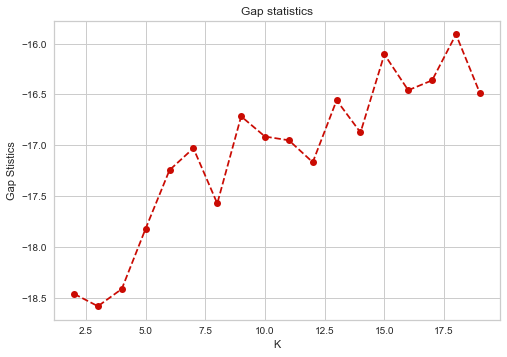

16

In [38]:
gap_stat(df_cl,20)

In [39]:
print(merged_df["track_genre_top"].unique())
print(len(merged_df["track_genre_top"].unique()))

['Hip-Hop' 'Pop' 'Folk' 'Jazz' 'Rock' '' 'Electronic' 'International'
 'Blues' 'Classical' 'Old-Time / Historic' 'Instrumental' 'Experimental']
13


In [39]:
kmeans = KMeans(n_clusters=9, init='k-means++').fit(df_cl)
kmeans.cluster_centers_

array([[ 2.40217018e+04,  5.03881551e+03,  5.20291794e+03, ...,
         5.42827511e-02,  2.14768414e-02,  2.08687357e-02],
       [ 3.17201343e+04,  6.44001373e+03,  6.46816998e+03, ...,
        -1.40965529e-03, -1.47479596e-02, -7.62023811e-03],
       [ 9.39717029e+03,  2.17199286e+03,  2.03762101e+03, ...,
        -4.15821298e-02, -1.21515165e-02, -1.91513927e-02],
       ...,
       [ 9.43279256e+04,  1.47696673e+04,  1.37723151e+04, ...,
        -9.14107420e-03, -7.79745834e-03,  3.31169239e-02],
       [ 2.56112252e+04,  5.38663576e+03,  6.05155629e+03, ...,
         6.73373145e-02,  3.23697015e-02, -9.03750227e-02],
       [ 4.18269523e+04,  8.16265308e+03,  7.90574913e+03, ...,
         1.72139364e-02, -1.75094100e-02, -3.30634749e-02]])

### 2.3.4: use the already implemented version of k-means++ 

The differences between the two algorithm is in the initialization of the centroids. 

We have used the library *yellowbrick* to visualize the optimal number of clusters and we have used different kinds of metrics to compute it. 

The metric *distortion* gives us back as optimal number of cluster 7.

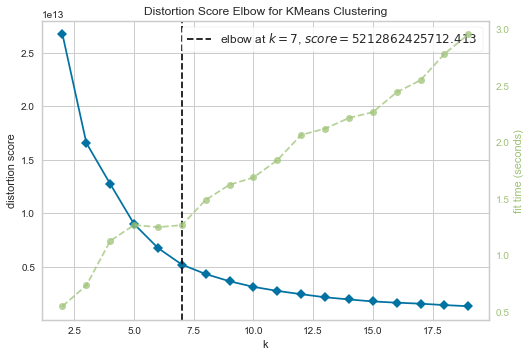

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [45]:
#Distortion
model = KMeans(init='k-means++')
visualizer = KElbowVisualizer(model, k = (2,20), metric = "distortion")
visualizer.fit(df_cl)
visualizer.show()

The metric *calinski_harabasz* and *silhouette* gives us back as optimal number of cluster 2. A really different result due to how these metrics are computed. 

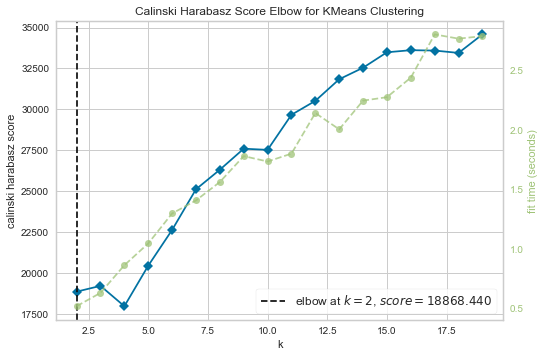

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [46]:
visualizer = KElbowVisualizer(model, k = (2,20), metric = "calinski_harabasz")
visualizer.fit(df_cl)
visualizer.show()

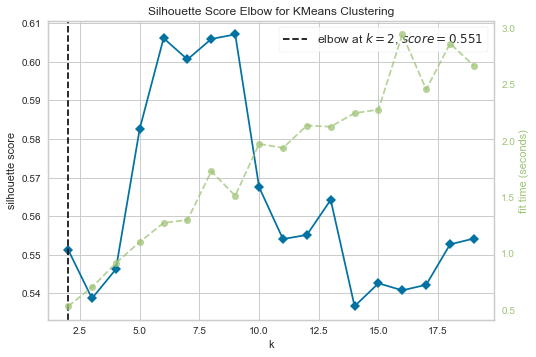

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [47]:
visualizer = KElbowVisualizer(model, k = (2,20), metric = "silhouette")
visualizer.fit(df_cl)
visualizer.show()

The way in which we have computed the cost for each K and consequently implemented the elbow method reproduce the metric *distortion* already implemented in the function *KElbowVisualizer* of the library *yellowbrick*. Indeed our optimal number of cluster obtained with the elbow method and this metric corrispond. As expected instead if we compute it with different metrics such as *silhouette* and *gap statistics*, the optimal number of cluster is different because it is computed with different criteria.

### 2.4 Analysing your results!

In [44]:
#We insert in our new dataframe the column "Cluster" corresponding to the cluster of that track.
df_cl.insert(1, "Clusters", clusters) 
df_cl

,track_id,Clusters,album_id,artist_id,track_bit_rate,track_duration,Comp_feat_0,Comp_feat_1,Comp_feat_2,Comp_feat_3,...,Comp_echo_70,Comp_echo_71,Comp_echo_72,Comp_echo_73,Comp_echo_74,Comp_echo_75,Comp_echo_76,Comp_echo_77,Comp_echo_78,Comp_echo_79
0,2,1,1,1,256000,-0.359550,2.060070,-3.089439,-5.565923,0.080540,...,0.279020,0.309030,0.151965,0.124042,-0.594117,-0.142229,-0.297583,-0.280814,0.375268,-1.125187
1,3,1,1,1,256000,-0.133704,3.509246,-5.384927,-4.332572,-1.113460,...,-0.606973,0.382901,0.606143,0.392855,-0.229257,0.663476,-0.912879,-0.814178,0.636481,-0.069900
2,5,1,1,1,256000,-0.235171,0.954593,-3.178022,-3.494718,-0.934800,...,-0.129739,0.523473,0.001077,-0.368345,0.161409,-0.330084,-0.688745,-0.236431,0.708398,-0.853495
3,10,6,6,6,192000,-0.382462,6.695430,1.329784,-5.129153,-0.915313,...,-1.635331,-1.366938,-0.581039,0.355240,1.384180,-0.410897,-0.355964,1.018830,0.807910,0.058125
4,134,1,1,1,256000,-0.231898,0.704723,-6.843220,-2.639587,-1.228864,...,-0.252428,0.284929,-0.047094,-0.861426,-0.406434,0.218645,0.058717,-0.377175,-0.491370,-0.251147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13124,124857,8,18862,20818,320000,-0.032237,5.654981,-5.399580,-0.732312,-0.470457,...,1.334808,1.463458,-0.457014,-0.209884,0.856674,-0.970378,-0.381521,0.007259,0.305488,0.016577
13125,124862,8,18862,20818,320000,-0.110792,14.575253,-3.654197,-1.060832,-1.135120,...,0.425777,0.439802,-0.057844,0.629191,0.687676,-0.195950,0.200343,-0.547724,1.469359,0.870934
13126,124863,8,18862,20818,320000,0.340899,16.215050,-4.070124,-2.227104,0.181623,...,1.055528,0.385942,-1.034497,-0.430408,0.312643,-1.441963,0.287619,-0.214938,0.582278,0.968539
13127,124864,8,18862,20818,320000,0.039771,-2.644731,-2.042654,-2.478634,-0.733208,...,-0.756048,0.496645,-0.575793,-0.008397,-0.323770,0.740124,0.143663,0.052084,0.654946,0.200371


To identify the genre of a song we have selected six features: as suggested we have picked *track_language* and *track_duration*. Moreover we have surfed on internet to understand what are the important feature to understand the genre of a song. We have come up with the following features: *audio_features_acousticness*, *audio_features_danceability*, *audio_features_energy*, *audio_features_instrumentalness*. They are all numerical features except for *track_language*. As requested we have categorized each them in four categories through the function of pandas *cut* or *qcut*.

Before of the catgorization we have standardized these features, in particular we have had some troubles with the track duration because there were outliers that have driven to wrong categorization. 

In [47]:
pivot = pd.DataFrame()
a = []
for i in range(1,5):
    pivot.insert(i-1, echonest.columns[i], pd.cut(echonest[echonest.columns[i]], bins = 4,labels=["1", "2", "3", "4"])) 
pivot.insert(0,"track_duration",pd.qcut(df_cl[df_cl.columns[5]], q = 4,labels=["1", "2", "3", "4"]))
pivot.insert(0,"track_language",pd.qcut(df_cl[df_cl.columns[1]], q = 4,labels=["1", "2", "3", "4"]))
pivot.insert(0, "Clusters", clusters)
pivot

,Clusters,track_language,track_duration,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness
0,1,1,2,2,3,3,1
1,1,1,3,2,3,4,1
2,1,1,2,1,4,3,1
3,6,2,2,4,3,4,4
4,1,1,2,2,3,3,1
...,...,...,...,...,...,...,...
13124,8,3,3,1,4,3,4
13125,8,3,3,1,4,3,4
13126,8,3,4,1,3,4,4
13127,8,3,4,2,3,3,2


### Pivot

In [120]:
#acoustiness
t = np.zeros((4,12))
l = []
for j in range(0,4):
    for i in range(0,12):
        t[j][i] = ((pivot[(pivot.audio_features_acousticness == str(j+1)) & (pivot.Clusters == i+1)].count()[0]))

for i in range(t.shape[1]):
    t[:,i] = np.around((t[:,i]/sum(t)[i])*100,4)
l = []
for i in range(1,13):
    l.append("Cluster "+str(i))
acoustiness_pivot = pd.DataFrame(t)
acoustiness_pivot.columns = l
acoustiness_pivot.loc[4] = sum(t)
acoustiness_pivot.rename(index={4: 'Tot'})
acoustiness_pivot


,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,Cluster 11,Cluster 12
0,26.4368,44.6134,28.7179,47.3151,66.5339,39.7272,20.8763,23.2026,39.9618,17.7271,43.1416,59.5563
1,10.0796,13.3510,13.0484,12.7660,10.9562,13.9812,8.8488,11.7647,13.3843,10.9258,13.6062,15.3584
2,9.8143,13.0866,14.6439,13.2725,8.1673,13.8107,14.3471,15.0327,13.5755,14.8311,11.3938,8.3618
3,53.6693,28.9491,43.5897,26.6464,14.3426,32.4808,55.9278,50.0000,33.0784,56.5160,31.8584,16.7235
4,100.0000,100.0001,99.9999,100.0000,100.0000,99.9999,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000


In [121]:
#danceability
t = np.zeros((4,12))
l = []
for j in range(0,4):
    for i in range(0,12):
        t[j][i] = ((pivot[(pivot.audio_features_danceability == str(j+1)) & (pivot.Clusters == i+1)].count()[0]))

for i in range(t.shape[1]):
    t[:,i] = np.around((t[:,i]/sum(t)[i])*100,4)
l = []
for i in range(1,13):
    l.append("Cluster "+str(i))
danceability_pivot = pd.DataFrame(t)
danceability_pivot.columns = l
danceability_pivot.loc[4] = sum(t)
danceability_pivot.rename(index={4: 'Tot'})
danceability_pivot

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,Cluster 11,Cluster 12
0,17.5950,8.7905,17.6638,12.5633,15.7371,12.6172,16.1512,23.0392,21.9885,20.7986,12.6106,7.6792
1,38.1079,26.1732,35.0427,34.8531,47.4104,32.1398,45.8763,38.0719,47.0363,50.1536,34.1814,31.3993
2,32.3607,43.6880,35.6695,41.5400,32.8685,38.9599,30.7560,30.7190,27.7247,24.9671,41.7035,44.7099
3,11.9363,21.3483,11.6239,11.0436,3.9841,16.2830,7.2165,8.1699,3.2505,4.0807,11.5044,16.2116
4,99.9999,100.0000,99.9999,100.0000,100.0001,99.9999,100.0000,100.0000,100.0000,100.0000,99.9999,100.0000


In [122]:
#energy
t = np.zeros((4,12))
l = []
for j in range(0,4):
    for i in range(0,12):
        t[j][i] = ((pivot[(pivot.audio_features_energy == str(j+1)) & (pivot.Clusters == i+1)].count()[0]))

for i in range(t.shape[1]):
    t[:,i] = np.around((t[:,i]/sum(t)[i])*100,4)
l = []
for i in range(1,13):
    l.append("Cluster "+str(i))
energy_pivot = pd.DataFrame(t)
energy_pivot.columns = l
energy_pivot.loc[4] = sum(t)
energy_pivot.rename(index={4: 'Tot'})
energy_pivot

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,Cluster 11,Cluster 12
0,32.1839,15.2016,13.1054,15.0963,9.1633,19.6078,29.8969,15.0327,11.2811,22.3344,17.4779,9.7270
1,23.7843,26.8341,24.1026,25.2280,21.3147,30.3495,21.5636,26.4706,19.3117,26.6345,26.1062,22.0137
2,20.9549,32.7165,31.4530,30.6991,23.7052,27.0247,25.4296,33.4967,28.6807,27.1172,29.5354,32.2526
3,23.0769,25.2479,31.3390,28.9767,45.8167,23.0179,23.1100,25.0000,40.7266,23.9140,26.8805,36.0068
4,100.0000,100.0001,100.0000,100.0001,99.9999,99.9999,100.0001,100.0000,100.0001,100.0001,100.0000,100.0001


In [123]:
#instrumentalness
t = np.zeros((4,12))
l = []
for j in range(0,4):
    for i in range(0,12):
        t[j][i] = ((pivot[(pivot.audio_features_instrumentalness == str(j+1)) & (pivot.Clusters == i+1)].count()[0]))

for i in range(t.shape[1]):
    t[:,i] = np.around((t[:,i]/sum(t)[i])*100,4)
l = []
for i in range(1,13):
    l.append("Cluster "+str(i))
instrumentalness_pivot = pd.DataFrame(t)
instrumentalness_pivot.columns = l
instrumentalness_pivot.loc[4] = sum(t)
instrumentalness_pivot.rename(index={4: 'Tot'})
instrumentalness_pivot

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,Cluster 11,Cluster 12
0,24.6684,13.5492,16.5242,41.5400,63.7450,17.9028,9.2784,19.4444,29.4455,18.0342,31.0841,46.9283
1,5.4819,4.0317,5.3561,6.4843,5.9761,6.1381,5.8419,7.0261,5.1625,6.6257,4.7566,6.9966
2,8.3996,8.7905,11.4530,10.3343,10.1594,13.2992,10.1375,7.8431,10.1338,11.7157,10.3982,10.2389
3,61.4500,73.6286,66.6667,41.6413,20.1195,62.6598,74.7423,65.6863,55.2581,63.6244,53.7611,35.8362
4,99.9999,100.0000,100.0000,99.9999,100.0000,99.9999,100.0001,99.9999,99.9999,100.0000,100.0000,100.0000


In [124]:
#duration
t = np.zeros((4,12))
l = []
for j in range(0,4):
    for i in range(0,12):
        t[j][i] = ((pivot[(pivot.track_duration == str(j+1)) & (pivot.Clusters == i+1)].count()[0]))

for i in range(t.shape[1]):
    t[:,i] = np.around((t[:,i]/sum(t)[i])*100,4)
l = []
for i in range(1,13):
    l.append("Cluster "+str(i))
track_duration_pivot = pd.DataFrame(t)
track_duration_pivot.columns = l
track_duration_pivot.loc[4] = sum(t)
track_duration_pivot.rename(index={4: 'Tot'})

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,Cluster 11,Cluster 12
0,24.4916,20.9518,30.9972,24.9240,21.5139,23.1032,23.1100,26.3072,24.0918,28.2141,25.6637,17.5768
1,29.0009,21.1500,25.9259,27.3556,31.0757,22.3359,32.7320,23.2026,22.9446,23.3436,25.5531,20.8191
2,24.4032,27.9577,22.7920,28.6727,29.0837,25.2344,22.7663,25.8170,21.9885,20.8425,26.4381,29.6928
3,22.1043,29.9405,20.2849,19.0476,18.3267,29.3265,21.3918,24.6732,30.9751,27.5998,22.3451,31.9113
Tot,100.0000,100.0000,100.0000,99.9999,100.0000,100.0000,100.0001,100.0000,100.0000,100.0000,100.0000,100.0000


In [125]:
#language
t = np.zeros((4,12))
l = []
for j in range(0,4):
    for i in range(0,12):
        t[j][i] = ((pivot[(pivot.track_language == str(j+1)) & (pivot.Clusters == i+1)].count()[0]))

for i in range(t.shape[1]):
    t[:,i] = np.around((t[:,i]/sum(t)[i])*100,4)
l = []
for i in range(1,13):
    l.append("Cluster "+str(i))
track_language_pivot = pd.DataFrame(t)
track_language_pivot.columns = l
track_language_pivot.loc[4] = sum(t)

track_language_pivot

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,Cluster 11,Cluster 12
0,100.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,100.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,100.0,100.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0
4,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


### 2.7


In [30]:
merged = tracks.merge(features, on = "track_id")
merged

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,1,<p></p>,6073,,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,1,<p></p>,6073,,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,1,<p></p>,6073,,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,,4,6,,47632,,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
4,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106569,155316,0,2017-03-30 15:20:35,2017-02-17 00:00:00,,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,0.128410,0.022547,0.019816,4.448255,0.172852,0.028773,0.028320,0.003906,0.955388,0.012385
106570,155317,0,2017-03-30 15:20:35,2017-02-17 00:00:00,,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,0.132964,0.023548,0.026527,3.270612,0.196289,0.031116,0.027832,0.002441,1.283060,0.019059
106571,155318,0,2017-03-30 15:20:35,2017-02-17 00:00:00,,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,0.108324,0.017540,0.020471,2.356727,0.212891,0.038450,0.037109,0.003418,0.828569,0.017904
106572,155319,0,2017-03-30 15:20:35,2017-02-17 00:00:00,,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,0.088311,0.018328,0.017936,6.188604,0.167480,0.041480,0.038086,0.004883,1.818740,0.020133


## **3. Algorithmic Question** 

*You are given a list of integers, A, and another integer s. Write an algorithm that outputs all the pairs in A that equal x.*

I check all the possible pairs in my list with two for loops. If the sum of a pair is equal to my given sum I store my result. 

In [1]:
def algo(l, s):
    
    result = [] 
    n = len(l)                                #length of the starting list
    
    for i in range(len(l)):                   #first loop starts from the beginning of the list and scan all the list
        for j in range(i+1, len(l)):          #the second loop starts from the next number of the first loop
            if(l[i]+l[j] == s):             #check the given sum 
                result.append((l[i], l[j]))   #append the tuple in my final list 
    
    if len(result) == 0:                      #check if i have found at least one pair
        return("There is not any pair that gives as result " + str(s))
    else:
        return result

Try the algorithm with some examples.

In [2]:
l = [7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3] 
s = 4
algo(l, s)

[(7, -3), (-2, 6), (2, 2), (1, 3)]

In [4]:
l = [7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3] 
s = 10
algo(l, s)

[(7, 3), (8, 2), (8, 2), (6, 4)]

In [5]:
l = [7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3] 
s = -5
algo(l, s)

[(-2, -3), (2, -7), (-7, 2)]

In [3]:
l = [7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3] 
s = 100
algo(l, s)

'There is not any pair that gives as result 100'